In [ ]:
import os
import math
import pandas as pd
import numpy as np
import pprint
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [ ]:
random_state = 20

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Mcomp/CS5228/project/notebooks"
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Mcomp/CS5228/project/notebooks
model.ipynb


In [ ]:
is_baseline = True

if is_baseline:
    train_val_df = pd.read_csv("../data/train.csv")
    test_df = pd.read_csv("../data/test.csv")
else:
    train_val_df = pd.read_csv("../data/train_edited_v2.csv")
    test_df = pd.read_csv("../data/test_edited_v2.csv")

In [ ]:
test_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'eco_category', 'lease_commence_date',
       'latitude', 'longitude', 'elevation', 'subzone', 'planning_area',
       'region'],
      dtype='object')

In [ ]:
train_val_df = train_val_df.sample(frac=1)

train_prop = 0.7
num_train_val = train_val_df.shape[0]
num_train = int(train_prop*num_train_val)

train_df = train_val_df.iloc[:num_train]
val_df = train_val_df.iloc[num_train:]

In [ ]:
train_df["dataset"] = "train"
val_df["dataset"] = "val"
test_df["dataset"] = "test"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
combined_df = pd.concat([train_df, val_df, test_df])
combined_df.columns[combined_df.isna().any()].tolist()

['resale_price']

##### Preprocessing

check nan

In [ ]:
combined_df.isnull().sum().sort_index()/len(combined_df)

block                  0.000000
dataset                0.000000
eco_category           0.000000
elevation              0.000000
flat_model             0.000000
flat_type              0.000000
floor_area_sqm         0.000000
latitude               0.000000
lease_commence_date    0.000000
longitude              0.000000
month                  0.000000
planning_area          0.000000
region                 0.000000
resale_price           0.200001
storey_range           0.000000
street_name            0.000000
subzone                0.000000
town                   0.000000
dtype: float64

Select relevant columns

In [ ]:
def generate_new_features(features_df, is_baseline):
    # new features
    features_df_copy = features_df.copy()
    features_df_copy["flat_type"] = features_df_copy["flat_type"].apply(lambda x: x.replace("-", " "))

    if is_baseline:
        features_df_copy["month"] = features_df_copy["month"].astype('datetime64[ns]')
        features_df_copy["year"] = features_df_copy["month"].dt.year
        features_df_copy["min_storey"] = features_df_copy["storey_range"].apply(lambda x: int(x.split("to")[0].strip().replace("0", ""))).astype(int)
        features_df_copy["max_storey"] = features_df_copy["storey_range"].apply(lambda x: int(x.split("to")[1].strip().replace("0", ""))).astype(int)

        # remove unwanted columns
        features_df_copy = features_df_copy.drop(["month", "storey_range"], axis=1)
    else:
        features_df_copy["date"] = features_df_copy["date"].astype('datetime64[ns]')
        features_df_copy["month"] = features_df_copy["date"].dt.month

    return features_df_copy

In [ ]:
def cat_transform(combined_df):
    combined_df_copy = combined_df.copy()
    mapping = {
        "flat_type": {
            "1 room": 1, "2 room": 2,
            "3 room": 3, "4 room": 4,
            "5 room": 5, "executive": 6,
            "multi generation": 7
        }
    }
    combined_df_copy = combined_df_copy.replace(mapping)
    
    combined_df_copy = pd.get_dummies(combined_df_copy, columns=["planning_area"])

    return combined_df_copy

In [ ]:
def transform(combined_df, is_baseline):
    
    combined_df_new_f = generate_new_features(combined_df, is_baseline)
    
    transformed_combined_df = cat_transform(combined_df_new_f)
    
    return transformed_combined_df

In [ ]:
transformed_combined_df = transform(combined_df, is_baseline)
transformed_combined_df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,region,resale_price,dataset,year,min_storey,max_storey,planning_area_ang mo kio,planning_area_bedok,planning_area_bishan,planning_area_bukit batok,planning_area_bukit merah,planning_area_bukit panjang,planning_area_bukit timah,planning_area_changi,planning_area_choa chu kang,planning_area_clementi,planning_area_downtown core,planning_area_geylang,planning_area_hougang,planning_area_jurong east,planning_area_jurong west,planning_area_kallang,planning_area_marine parade,planning_area_novena,planning_area_outram,planning_area_pasir ris,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_sungei kadut,planning_area_tampines,planning_area_tanglin,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
39648,hougang,3,1,Hougang Avenue 3,59.0,improved,uncategorized,1975,1.364131,103.893001,0.0,kangkar,north-east region,123300.0,train,2005,13,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307399,punggol,5,213B,punggol walk,113.0,improved,uncategorized,2015,1.400720,103.898485,0.0,matilda,north-east region,522000.0,train,2019,16,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
220475,geylang,4,28,cassia crescent,101.0,model a,uncategorized,1998,1.308945,103.883530,0.0,aljunied,central region,276300.0,train,2002,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
195977,sengkang,5,403A,Fernvale Lane,111.0,premium apartment,uncategorized,2004,1.388931,103.873209,0.0,fernvale,north-east region,342000.0,train,2008,7,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
234100,sengkang,4,273D,Compassvale Link,90.0,premium apartment,uncategorized,2009,1.384141,103.894443,0.0,compassvale,north-east region,484200.0,train,2015,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107929,hougang,5,981D,buangkok crescent,110.0,improved,uncategorized,2003,1.380452,103.879333,0.0,trafalgar,north-east region,NaN,test,2008,1,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107930,kallang/whampoa,4,13,upper boon keng road,102.0,model a,uncategorized,1999,1.314481,103.870458,0.0,boon keng,central region,NaN,test,2006,13,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107931,kallang/whampoa,3,1,beach road,68.0,improved,uncategorized,1979,1.294924,103.854315,0.0,city hall,central region,NaN,test,2000,7,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107932,jurong west,4,919,jurong west street 91,104.0,model a,uncategorized,1988,1.339927,103.687354,0.0,yunnan,west region,NaN,test,2009,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
if is_baseline:
    columns_to_drop = ["town", "flat_type", "block", "street_name", "flat_model", "eco_category", "latitude", "longitude", "elevation", "subzone", "region"]
else:
    columns_to_drop = ["town", "flat_type", "street_name", "flat_model", "subzone", "region", "x", "y", "date", "mrt_2km", "mrt_1km", "prisch_2km", "prisch_1km", "secsch_2km", "secsch_1km", "markets_2km", "markets_1km", "malls_2km", "malls_1km", "comm_2km", "comm_1km", "district"]

transformed_combined_df_subset = transformed_combined_df.drop(columns_to_drop, axis=1)
transformed_combined_df_subset

,floor_area_sqm,lease_commence_date,resale_price,dataset,year,min_storey,max_storey,planning_area_ang mo kio,planning_area_bedok,planning_area_bishan,planning_area_bukit batok,planning_area_bukit merah,planning_area_bukit panjang,planning_area_bukit timah,planning_area_changi,planning_area_choa chu kang,planning_area_clementi,planning_area_downtown core,planning_area_geylang,planning_area_hougang,planning_area_jurong east,planning_area_jurong west,planning_area_kallang,planning_area_marine parade,planning_area_novena,planning_area_outram,planning_area_pasir ris,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_sungei kadut,planning_area_tampines,planning_area_tanglin,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
39648,59.0,1975,123300.0,train,2005,13,15,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307399,113.0,2015,522000.0,train,2019,16,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
220475,101.0,1998,276300.0,train,2002,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
195977,111.0,2004,342000.0,train,2008,7,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
234100,90.0,2009,484200.0,train,2015,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107929,110.0,2003,NaN,test,2008,1,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107930,102.0,1999,NaN,test,2006,13,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107931,68.0,1979,NaN,test,2000,7,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107932,104.0,1988,NaN,test,2009,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


After transforming, separate out the dataset again

In [ ]:
train_df_processed = transformed_combined_df_subset.query("dataset == 'train'")
val_df_processed = transformed_combined_df_subset.query("dataset == 'val'")
test_df_processed = transformed_combined_df_subset.query("dataset == 'test'")

In [ ]:
def get_features_labels(df):
    features_df = df.drop(["resale_price", "dataset"], axis=1)
    labels = df["resale_price"].ravel()
    
    return features_df, labels

In [ ]:
train_features_df, train_labels = get_features_labels(train_df_processed)
val_features_df, val_labels = get_features_labels(val_df_processed)
test_features_df, test_labels = get_features_labels(test_df_processed)

In [ ]:
val_features_df

,floor_area_sqm,lease_commence_date,year,min_storey,max_storey,planning_area_ang mo kio,planning_area_bedok,planning_area_bishan,planning_area_bukit batok,planning_area_bukit merah,planning_area_bukit panjang,planning_area_bukit timah,planning_area_changi,planning_area_choa chu kang,planning_area_clementi,planning_area_downtown core,planning_area_geylang,planning_area_hougang,planning_area_jurong east,planning_area_jurong west,planning_area_kallang,planning_area_marine parade,planning_area_novena,planning_area_outram,planning_area_pasir ris,planning_area_punggol,planning_area_queenstown,planning_area_rochor,planning_area_sembawang,planning_area_sengkang,planning_area_serangoon,planning_area_sungei kadut,planning_area_tampines,planning_area_tanglin,planning_area_toa payoh,planning_area_woodlands,planning_area_yishun
235010,101.0,1999,2003,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
168241,100.0,1999,2007,19,21,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
187624,91.0,1985,2017,7,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
135027,110.0,2003,2015,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
207756,59.0,1974,2015,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294733,121.0,1998,2002,13,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
354252,67.0,1969,2020,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
70221,98.0,1978,2016,7,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157469,59.0,1978,2019,7,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Metrics

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    
    return rmse

def calculate_rmse(features_df, labels):
    preds = rf.predict(features_df)
    rmse = root_mean_squared_error(labels, preds)

    return rmse

#### RandomSearch

In [ ]:
def run_random_search_cv(model, grid, train_features_df, train_labels, test_features_df, random_state=random_state, n_iter=5):

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    m = model(random_state=random_state)

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    random_search = RandomizedSearchCV(
        estimator=m, param_distributions=grid, n_iter=n_iter, scoring=make_scorer(root_mean_squared_error),
        cv=2, verbose=10, random_state=random_state, n_jobs = -1, error_score="raise"
    )

    # Fit the random search model
    random_search.fit(train_features_df, train_labels)
    test_labels = random_search.predict(test_features_df)

    return random_search, test_labels

#### GridSearch

In [ ]:
def run_grid_search_cv(model, grid, train_features_df, train_labels, test_features_df, random_state=random_state):
    
    # Create a based model
    m = model(random_state=random_state)
    # Instantiate the grid search model
    grid_search = GridSearchCV(
        estimator=m, param_grid=grid, scoring=make_scorer(root_mean_squared_error),
        cv=3, n_jobs=-1, verbose=10, error_score="raise"
    )

    # Fit the grid search to the data
    grid_search.fit(train_features_df, train_labels)
    test_labels = grid_search.predict(test_features_df)
    
    return grid_search, test_labels

#### Run GridSearch or RandomSearch on multiple models

In [ ]:
def run_search_on_multiple_models(models, model_names, grids, train_features_df, train_labels, test_features_df, search_type="random_search", n_iter=3):
    search_results = {}

    for model_name in model_names:
        grid = grids[model_name]
        model = models[model_name]
        
        if search_type == "random_search":
            search_result = run_random_search_cv(model, grid, train_features_df, train_labels, test_features_df, n_iter=n_iter)
        elif search_type == "grid_search":
            search_result = run_grid_search_cv(model, grid, train_features_df, train_labels, test_features_df)
        search_results[model_name] = search_result
    
    return search_results

In [ ]:
models = {
    "RandomForestRegressor": RandomForestRegressor,
    "GradientBoostingRegressor": GradientBoostingRegressor
}

model_names = ["RandomForestRegressor", "GradientBoostingRegressor"]




RandomSearch

In [ ]:
# Number of trees in random forest
n_estimators = [50, 100]

# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [100, 200, 500, 1000]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 50, 100, 200]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 50, 100, 200]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}


random_grids = {
    "RandomForestRegressor": random_grid,
    "GradientBoostingRegressor": random_grid
}

In [ ]:
train_labels

array([123300., 522000., 276300., ..., 340200., 513000., 495000.])

In [ ]:
random_search_results = run_search_on_multiple_models(models, model_names, random_grids, train_features_df, train_labels, test_features_df, search_type="random_search")

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.1min remaining:   34.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.0min finished


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.1min finished


In [ ]:
random_search_feature_impt_results = defaultdict()
for model_name in model_names:
    print(model_name)
    print("Best Params")
    print(random_search_results[model_name][0].best_params_)
    print("Best Score")
    print(random_search_results[model_name][0].best_score_)
    print("Feature importance Params")
    raw_feature_importances = random_search_results[model_name][0].best_estimator_.feature_importances_
    random_search_feature_impt_results[model_name] = raw_feature_importances
    feature_importances = sorted(list(zip(train_features_df.columns, raw_feature_importances)), key=lambda x: x[1], reverse=True)
    print(feature_importances)
    print("Best Params Predictions")
    print(random_search_results[model_name][1])
    print("\n")

RandomForestRegressor
Best Params
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 500}
Best Score
42376.55060306263
Feature importance Params
[('year', 0.407874005567359), ('floor_area_sqm', 0.32139095644357496), ('lease_commence_date', 0.10462977938603374), ('min_storey', 0.03419193822493814), ('max_storey', 0.025847376011237825), ('planning_area_bukit merah', 0.016410957763948637), ('planning_area_queenstown', 0.01134033013800783), ('planning_area_woodlands', 0.01068230871073695), ('planning_area_bishan', 0.00958082569161478), ('planning_area_toa payoh', 0.006318051975153182), ('planning_area_jurong west', 0.005687346381126215), ('planning_area_sengkang', 0.004396391561637735), ('planning_area_yishun', 0.004300822039893565), ('planning_area_choa chu kang', 0.004036076636002892), ('planning_area_punggol', 0.003966547310985802), ('planning_area_tampines', 0.0031055683982251295), ('planning_area_pasir ris', 0.00310374370763658),

GridSearch

In [ ]:
# Number of trees in random forest
n_estimators = [100, 200]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [500]
# max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [50]

# Create the random grid
grid_search_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}


grid_search_grids = {
    "RandomForestRegressor": grid_search_grid,
    "GradientBoostingRegressor": grid_search_grid
}

In [ ]:
grid_search_results = run_search_on_multiple_models(models, model_names, grid_search_grids, train_features_df, train_labels, test_features_df, search_type="grid_search")

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.3min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  4.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.1min finished


In [ ]:
grid_search_feature_impt_results = defaultdict()
for model_name in model_names:
    print(model_name)
    print("Best Params")
    print(grid_search_results[model_name][0].best_params_)
    print("Feature importance Params")
    raw_feature_importances = grid_search_results[model_name][0].best_estimator_.feature_importances_
    grid_search_feature_impt_results[model_name] = raw_feature_importances
    feature_importances = sorted(list(zip(train_features_df.columns, raw_feature_importances)), key=lambda x: x[1], reverse=True)
    print(feature_importances)
    print("Best Params Predictions")
    print(grid_search_results[model_name][1])
    print("\n")

RandomForestRegressor
Best Params
{'max_depth': 500, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 5, 'n_estimators': 100}
Feature importance Params
[('year', 0.407874005567359), ('floor_area_sqm', 0.32139095644357496), ('lease_commence_date', 0.10462977938603374), ('min_storey', 0.03419193822493814), ('max_storey', 0.025847376011237825), ('planning_area_bukit merah', 0.016410957763948637), ('planning_area_queenstown', 0.01134033013800783), ('planning_area_woodlands', 0.01068230871073695), ('planning_area_bishan', 0.00958082569161478), ('planning_area_toa payoh', 0.006318051975153182), ('planning_area_jurong west', 0.005687346381126215), ('planning_area_sengkang', 0.004396391561637735), ('planning_area_yishun', 0.004300822039893565), ('planning_area_choa chu kang', 0.004036076636002892), ('planning_area_punggol', 0.003966547310985802), ('planning_area_tampines', 0.0031055683982251295), ('planning_area_pasir ris', 0.00310374370763658), ('planning_area_kallang', 0.

#### Feature Selection

There is a sklearn webpage which highlighted that the impurity-based feature importance of RandomForestClassifier (I guess it applies to regressor to) can inflate the importance of the features with high cardinality. Furthermore, impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity). The webpage suggests that Permutation Importances can be used as an alternative that can mitigate those limitations.

In [ ]:
def plot_impt(impt_arr, labels, model_name, impt_type):
    fig, ax = plt.subplots()
    ax.boxplot(impt_arr,
               vert=False, labels=labels)
    ax.set_title(f"{model_name}'s' {impt_type}")
    fig.tight_layout()
    plt.show()

Permutation Importance

In [ ]:
def run_perm_impt(model, X_val, y_val, n_repeats=10, random_state=random_state, n_jobs=2):
    
    result = permutation_importance(
        model, X_val, y_val, n_repeats=n_repeats,
        random_state=random_state, n_jobs=n_jobs
    )
    sorted_idx = result.importances_mean.argsort()
    perm_impt_arr = result.importances[sorted_idx].T
    labels = X_val.columns[sorted_idx]
    return perm_impt_arr, labels

In [57]:
perm_impt_results = defaultdict()
for model_name in model_names:
    best_estimator = grid_search_results[model_name][0].best_estimator_
    perm_impt_arr, labels = run_perm_impt(best_estimator, val_features_df, val_labels)
    perm_impt_results[model_name] = (perm_impt_arr, labels)

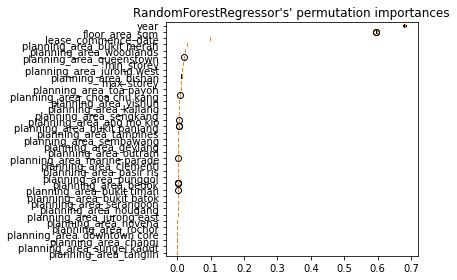

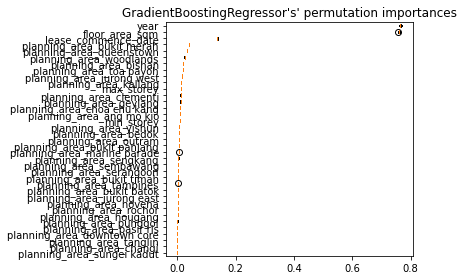

In [58]:
for model_name in model_names:
    model_perm_impt_results = perm_impt_results[model_name]
    plot_impt(model_perm_impt_results[0], model_perm_impt_results[1], model_name, "permutation importances")

Feature importance

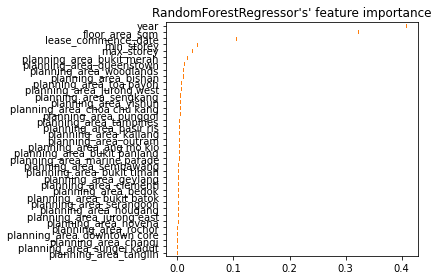

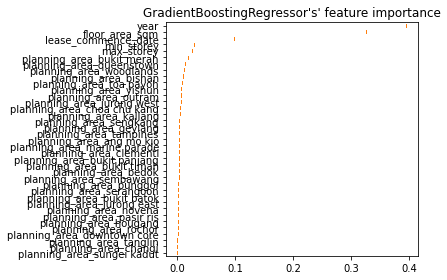

In [59]:
for model_name in model_names:
    model_feature_impt = grid_search_feature_impt_results[model_name]
    sorted_idx = model_feature_impt.argsort()
    model_feature_impt_arr = model_feature_impt[sorted_idx].T.reshape(1,-1)
    labels = train_features_df.columns[sorted_idx]
    plot_impt(model_feature_impt_arr, labels, model_name, "feature importance")

Seems to have roughly the same feature ordering as random forest's inbuild feature importance

#### Ensemble predictions

In [60]:
predictions = [r[1] for r in random_search_results.values()]
average_predictions = np.mean(predictions, axis=0)
average_predictions

array([196944.45307451, 328006.94501171, 126898.63908449, ...,
       151375.53794393, 259609.07250525, 336050.19553322])

In [61]:
submission = pd.DataFrame()
submission["Id"] = range(average_predictions.shape[0])
submission["Predicted"] = average_predictions

In [63]:
if is_baseline:
    submission.to_csv("baseline_submission.csv", index=False)
else:
    submission.to_csv("submission.csv", index=False)